# Line intensity comparison Tool
####Created by Jacklyn Pezzato in May 2016 as "PlotSpectra"

#####Plug in header-removed .dat file after creating a fit in XSPEC. First section plots spectra (allows for user-specified ranges) and second section plots spectra and calculates line flux ratios for specified lines (allows for user-specified ranges).

In [572]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [573]:
# set plot sizes for spectra
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams['font.size'] = 16

###SECTION 0: Read in header-removed data file

In [574]:
# read in ****HEADER-REMOVED**** .dat file from xspec
#datafile = np.recfromtxt('/home/jpezzat1/zpup/savefits/5frozentemp_repNeely_CNOfree_22FEB2016.dat', names=('wvlth','binw','data1','errdata','fit'))
#datafile = np.recfromtxt('/Users/home/Desktop/jackie/5frozentemp_repNeely_CNOfree_22FEB2016.dat', names=('wvlth','binw','data1','errdata','fit'))
datafile = np.recfromtxt('/Users/home/Dropbox/astro_projects/abundances/plotting/5T_nonsolar_10jun16a.dat', names=('wvlth','binw','data1','errdata','fit'))

In [575]:
# find break in data 1 and data 2
no = []
for i in range(len(datafile.wvlth)):
    if (datafile.wvlth[i]=='NO'):
        no.append(i)

# make variables
L1 = np.array(map(float,datafile.wvlth[0:(no[0])]))
binw1 = np.array(map(float,datafile.binw[0:(no[0])]))
data1 = np.array(map(float,datafile.data1[0:(no[0])]))
err1 = np.array(map(float,datafile.errdata[0:(no[0])]))
model1 = np.array(map(float,datafile.fit[0:(no[0])]))

L2 = np.array(map(float,datafile.wvlth[(no[0]+1):]))
binw2 = np.array(map(float,datafile.binw[(no[0]+1):]))
data2 = np.array(map(float,datafile.data1[(no[0]+1):]))
err2 = np.array(map(float,datafile.errdata[(no[0]+1):]))
model2 = np.array(map(float,datafile.fit[(no[0]+1):]))

# if your file contains only one data set: comment out L2-model2 lines
# if your file contains j data sets: to get the jth Lj-modelj, cut from no[j-1] and end at no[j]+1

###SECTION 1: Plot the spectra

In [576]:
# raw spectrum plotting tool
def plotspecraw(wlarray,dataarray,modelarray,errarray,binwarray, title):
    plt.errorbar(wlarray,dataarray,ecolor='b',yerr=errarray,fmt='none', label='Data')
    plt.errorbar(wlarray,modelarray,ecolor='k',xerr=binwarray,fmt='none', label='Model')
    plt.xlim([np.min(wlarray)-.2,np.max(wlarray)+.2])
    plt.ylim([np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02])
    plt.title(title)
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Count Rate (cts s$^{-1}$ $\AA^{-1}$)')
    plt.legend()
    plt.show
    
# function to determine the index of points closest to the desired values
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

# raw spectrum plotting function with user selected ranges
def rangeplotspecraw(x_min,x_max,wlarray,dataarray,modelarray,errarray,binwarray, title):
    plt.errorbar(wlarray,dataarray,ecolor='b',yerr=errarray,fmt='none', label='Data')
    plt.errorbar(wlarray,modelarray,ecolor='k',xerr=binwarray,fmt='none', label='Model')
    plt.xlim([x_min-.2, x_max+.2])
    imin = find_nearest(wlarray, x_min)
    imax = find_nearest(wlarray, x_max)
    plt.ylim([np.min([np.min(dataarray[imin:imax]),np.min(modelarray[imin:imax])])-.02,np.max([np.max(dataarray[imin:imax]),np.max(modelarray[imin:imax])])+.02])
    plt.title(title)
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Count Rate (cts s$^{-1}$ $\AA^{-1}$)')
    plt.legend()
    plt.show

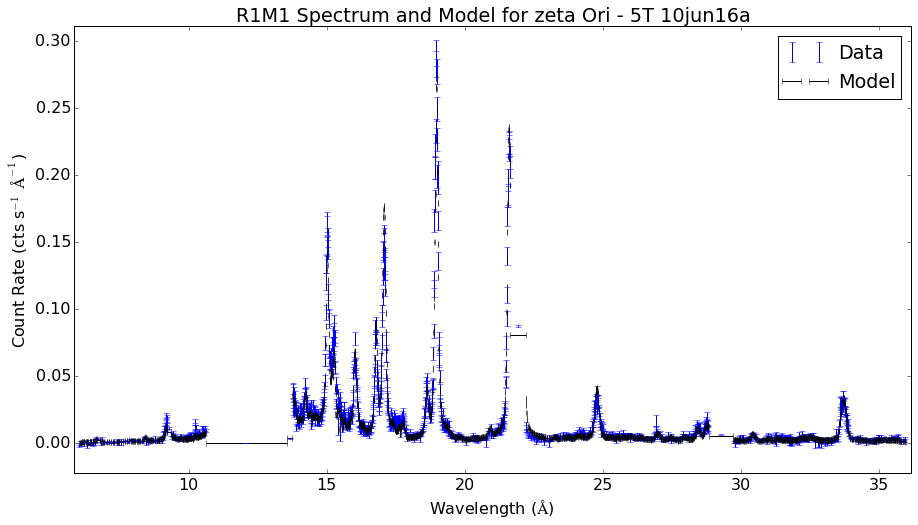

In [578]:
# make a plot of model1
plotspecraw(L1, data1, model1, err1, binw1, "R1M1 Spectrum and Model for zeta Ori - 5T 10jun16a")

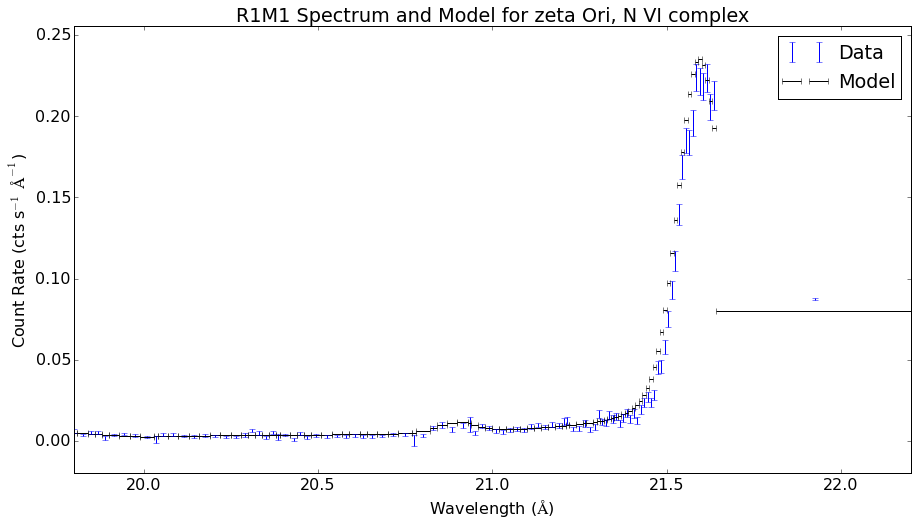

In [579]:
# range plot
rangeplotspecraw(20,22, L1,data1,model1,err1,binw1,'R1M1 Spectrum and Model for zeta Ori, N VI complex')

### SECTION 2: Plot the Spectra with model/data line ratios calculated

In [580]:
# function to integrate between values
def flux(lbound, ubound, wlarray, valuearray): # need wavelength array to set bounds for integration
    ilo = find_nearest(wlarray, lbound)
    iup = find_nearest(wlarray, ubound)
    flux = np.trapz(valuearray[ilo:iup]) #integrate using trapezoidal rule
    npoints = iup-ilo
    return [flux,npoints]

# function to get an average flux/angstrom continuum value
def contflux(llbound, ulbound, lrbound, urbound, wlarray, valuearray):
    [lflux,nl] = flux(llbound, ulbound, wlarray, valuearray)
    [rflux,nr] = flux(lrbound, urbound, wlarray, valuearray)
    contflux = (lflux + rflux)/(nl+nr)
    return contflux

# function to determine the model/data ratio with continuum subtracted out
def calcratio(lbound, ubound, wlarray, dataarray, modelarray, llbound, ulbound, lrbound, urbound): #last 4 for contflux
    [f_data, ndata] = flux(lbound, ubound, wlarray, dataarray)
    [f_model, nmodel] = flux(lbound, ubound, wlarray, modelarray)
    fcont_data = ndata*contflux(llbound, ulbound, lrbound, urbound, wlarray, dataarray)
    fcont_model = nmodel*contflux(llbound, ulbound, lrbound, urbound, wlarray, modelarray)
    ratio = (f_model-fcont_model)/(f_data-fcont_data)
    return ratio


In [581]:
# load in a .txt file containing the information needed to calculate the line fluxes
# file may need to be adjusted for different data sets, as different lines may be strong/weak
# 
# file should have rows with the format:
# line name   right boundary    left boundary   lower left boundary   upper left boundary   lower right boundary   upper right boundary
# 
# note that the 2nd and 3rd columns are used to calculate the flux of the actual line and that the 4th through 7th columns
# are used to estimate the amount of continuum emission around that line


#only the filename needs to be modified
#linefile = np.recfromtxt('/Users/home/Desktop/jackie/zpup_linelist.txt', names=('n','l','r','ll','ul','lr','ur'))
linefile = np.recfromtxt('/Users/home/Dropbox/astro_projects/abundances/plotting/zori_linelist.txt', names=('n','l','r','ll','ul','lr','ur'))

name = linefile.n
lbound = np.array(map(float,linefile.l))
rbound = np.array(map(float,linefile.r))
llbound = np.array(map(float,linefile.ll))
ulbound = np.array(map(float,linefile.ul))
lrbound = np.array(map(float,linefile.lr))
urbound = np.array(map(float,linefile.ur))


In [582]:
#now get ratio array
ratio1 = []
ratio2 = []
avecont_data1 = []
avecont_model1 = []
avecont_data2 = []
avecont_model2 = []
loc = [] # location to plot the ratios
for i in range(len(name)):
    ratio1.append(calcratio(lbound[i], rbound[i], L1, data1, model1, llbound[i], ulbound[i], lrbound[i], urbound[i]))
    ratio2.append(calcratio(lbound[i], rbound[i], L2, data2, model2, llbound[i], ulbound[i], lrbound[i], urbound[i]))
    loc.append(((rbound[i]-lbound[i])/2.0)+lbound[i])
    
    #to show continuum fit we need these varaibles
    avecont_data1.append(contflux(llbound[i], ulbound[i], lrbound[i], urbound[i], L1, data1))
    avecont_model1.append(contflux(llbound[i], ulbound[i], lrbound[i], urbound[i], L1, model1))
    avecont_data2.append(contflux(llbound[i], ulbound[i], lrbound[i], urbound[i], L2, data2))
    avecont_model2.append(contflux(llbound[i], ulbound[i], lrbound[i], urbound[i], L2, model2))
    
# to be robust, check for any 'nan' from a divide by zero, and set that ratio = 0
for i in range(len(ratio1)):
    if (np.isnan(ratio1[i])):
        ratio1[i]=0
    if (np.isnan(ratio2[i])):
        ratio2[i]=0


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


In [583]:
# full spectrum plotting function
def plotspecfull(wlarray,dataarray,modelarray,errarray,binwarray,ratio,loc,names,avecont_data,avecont_model,llbound,ulbound,lbound,rbound,lrbound,urbound,title):
    ax1 = plt.subplot2grid((4,1),(0,0),rowspan=3)
    plt.tight_layout(pad=0.1, w_pad=.1, h_pad=.1)
    ax1.errorbar(wlarray,dataarray,ecolor='b',yerr=errarray,fmt='none', label='Data')
    ax1.errorbar(wlarray,modelarray,ecolor='k',xerr=binwarray,fmt='none', label='Model')
    ax1.vlines(lbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dashed',colors='k') # plot vertical lines for each lbound
    ax1.vlines(rbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dashed',colors='k') # plot vertical lines for each rbound
    ax1.vlines(llbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dotted',colors='g') # plot vertical lines for each llbound
    ax1.vlines(ulbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dotted',colors='m') # plot vertical lines for each ulbound
    ax1.vlines(lrbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dotted',colors='g') # plot vertical lines for each lrbound
    ax1.vlines(urbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dotted',colors='m') # plot vertical lines for each urbound
        
    ax1.hlines(avecont_data, llbound, urbound, color='b', linestyles='dotted', lw=3) #display fits of continnum emission
    ax1.hlines(avecont_model, llbound, urbound, color='k', linestyles='dotted', lw=3)
    
    #label the lines and identify ratio outliers
    outlier_high = []
    high_x = []
    outlier_low = []
    low_x = []
    for i in range(len(names)):
        ax1.text(loc[i], -.005, names[i], fontsize='12', rotation='vertical', color='red')
        if (ratio[i]>2):
            outlier_high.append(loc[i])
            high_x.append(1.95)
        if (ratio[i]<.5):
            outlier_low.append(loc[i])
            low_x.append(.55)
    
    ax1.set_xlim([np.min(wlarray)-.2,np.max(wlarray)+.2])
    ax1.set_ylim([np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02])
    ax1.set_title(title)
    ax1.set_xlabel('Wavelength ($\AA$)')
    ax1.set_ylabel('Count Rate (cts s$^{-1}$ $\AA^{-1}$)')
    ax1.legend()
    plt.show()
    
    ax2 = plt.subplot2grid((4,1),(2,0),rowspan=1)
    plt.tight_layout(pad=0.1,w_pad=.1, h_pad=.1)
    ax2.scatter(loc,ratio, color='k', s=40)
    ax2.scatter(outlier_high, high_x, color='r', marker='^', s=60)
    ax2.scatter(outlier_low, low_x, color='r', marker='v', s=60)
    ax2.hlines(1,np.min(wlarray)-1, np.max(wlarray)+1) # horizontal line at 1 for entire xrange (1 is agreement)
    ax2.hlines(.8,np.min(wlarray)-1, np.max(wlarray)+1, color = 'k', linestyles='dashed') # horizontal line for 20% below
    ax2.hlines(1.25,np.min(wlarray)-1, np.max(wlarray)+1, color = 'k', linestyles='dashed') # horizontal line for 25% above
    ax2.set_xlim([np.min(wlarray)-.2,np.max(wlarray)+.2])
    ax2.set_ylim([.5,2])
    ax2.set_title('Line Flux Ratios')
    ax2.set_xlabel('Wavelength ($\AA$)')
    ax2.set_ylabel('Flux Model/Flux Data')
    plt.show()
  
# full spectrum plotting function with user specified ranges
def plotspecrange(x_min, x_max, wlarray,dataarray,modelarray,errarray,binwarray,ratio,loc,names,avecont_data,avecont_model,llbound,ulbound,lbound,rbound,lrbound,urbound,title):
    
    ax1 = plt.subplot2grid((4,1),(0,0),rowspan=3)
    plt.tight_layout(pad=0.1, w_pad=.1, h_pad=.1)
    ax1.errorbar(wlarray,dataarray,ecolor='b',yerr=errarray,fmt='none', label='Data')
    ax1.errorbar(wlarray,modelarray,ecolor='k',xerr=binwarray,fmt='none', label='Model')
    imin = find_nearest(wlarray, x_min)
    imax = find_nearest(wlarray, x_max)
    ax1.vlines(lbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dashed',colors='k') # plot vertical lines for each lbound
    ax1.vlines(rbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dashed',colors='k') # plot vertical lines for each rbound
    ax1.vlines(llbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dotted',colors='g') # plot vertical lines for each llbound
    ax1.vlines(ulbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dotted',colors='m') # plot vertical lines for each ulbound
    ax1.vlines(lrbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dotted',colors='g') # plot vertical lines for each lrbound
    ax1.vlines(urbound, np.min([np.min(dataarray),np.min(modelarray)])-.02,np.max([np.max(dataarray),np.max(modelarray)])+.02, linestyles='dotted',colors='m') # plot vertical lines for each urbound
    
    ax1.hlines(avecont_data, llbound, urbound, color='b', linestyles=':', lw=3) #display fits of continnum emission
    ax1.hlines(avecont_model, llbound, urbound, color='k', linestyles=':', lw=3)
    
    #label the lines
    outlier_high = []
    high_x = []
    outlier_low = []
    low_x = []
    for i in range(len(names)):
        if ((loc[i]>x_min)&(loc[i]<x_max)):
            ax1.text(loc[i], 0, names[i], fontsize='11', rotation='vertical', color='red')
        if (ratio[i]>2):
            outlier_high.append(loc[i])
            high_x.append(1.95)
        if (ratio[i]<.5):
            outlier_low.append(loc[i])
            low_x.append(.55)
    
    ax1.set_xlim([x_min-.2,x_max+.2])
    ax1.set_ylim([np.min([np.min(dataarray[imin:imax]),np.min(modelarray[imin:imax])])-.002,np.max([np.max(dataarray[imin:imax]),np.max(modelarray[imin:imax])])+.002])
    ax1.set_title(title)
    ax1.set_xlabel('Wavelength ($\AA$)')
    ax1.set_ylabel('Count Rate (cts s$^{-1}$ $\AA^{-1}$)')
    ax1.legend()
    plt.show()
    
    ax2 = plt.subplot2grid((4,1),(2,0),rowspan=1)
    plt.tight_layout(pad=0.1,w_pad=.1, h_pad=.1)
    ax2.scatter(loc,ratio, color='k', s=40)
    ax2.scatter(outlier_high, high_x, color='r', marker='^', s=60)
    ax2.scatter(outlier_low, low_x, color='r', marker='v', s=60)
    ax2.hlines(1,np.min(wlarray)-1, np.max(wlarray)+1) # horizontal line at 1 for entire xrange (1 is agreement)
    ax2.hlines(.8,np.min(wlarray)-1, np.max(wlarray)+1, color = 'k', linestyles='dashed') # horizontal line for 20% below
    ax2.hlines(1.25,np.min(wlarray)-1, np.max(wlarray)+1, color = 'k', linestyles='dashed') # horizontal line for 25% above
    ax2.set_xlim([x_min-.2,x_max+.2])
    ax2.set_ylim([.5,2])
    ax2.set_title('Line Flux Ratios')
    ax2.set_xlabel('Wavelength ($\AA$)')
    ax2.set_ylabel('Flux Model/Flux Data')
    plt.show()
    

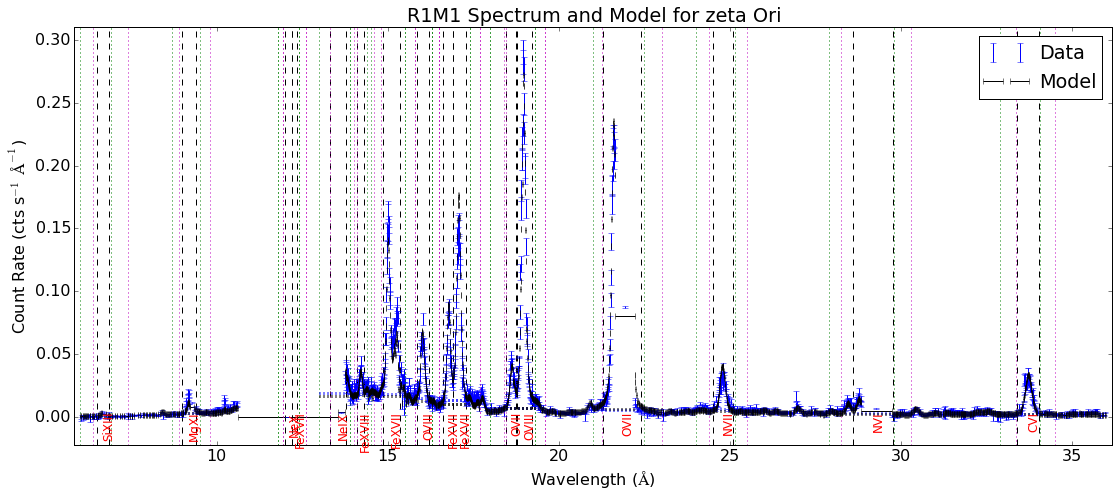

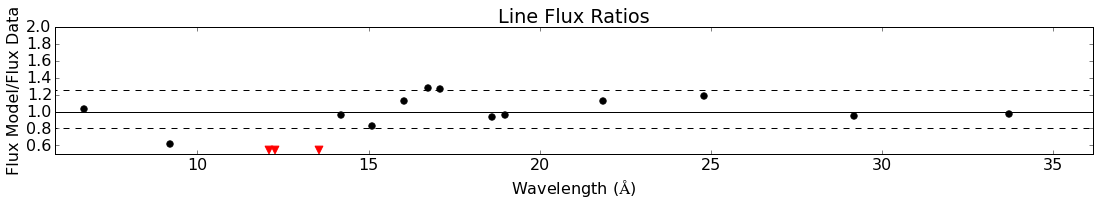

([33.710000000000001,
  29.175000000000001,
  24.800000000000001,
  21.850000000000001,
  18.984999999999999,
  18.600000000000001,
  17.100000000000001,
  16.75,
  16.024999999999999,
  15.1,
  14.199999999999999,
  13.539999999999999,
  12.274999999999999,
  12.1,
  9.1999999999999993,
  6.6749999999999998],
 [0.97374998395520118,
  0.94763282872311128,
  1.182125853269326,
  1.1280619532824607,
  0.95681538335259098,
  0.93642533734569988,
  1.2627182337025498,
  1.2739644252960198,
  1.1204765799265919,
  0.83141038377067056,
  0.956710514804755,
  -1.1116303601637076,
  0,
  0,
  0.61671966519274046,
  1.0324518825949127])

In [584]:
plotspecfull(L1, data1, model1, err1, binw1,ratio1,loc,name,avecont_data1,avecont_model1,llbound,ulbound,lbound,rbound,lrbound,urbound,"R1M1 Spectrum and Model for zeta Ori")
loc, ratio1

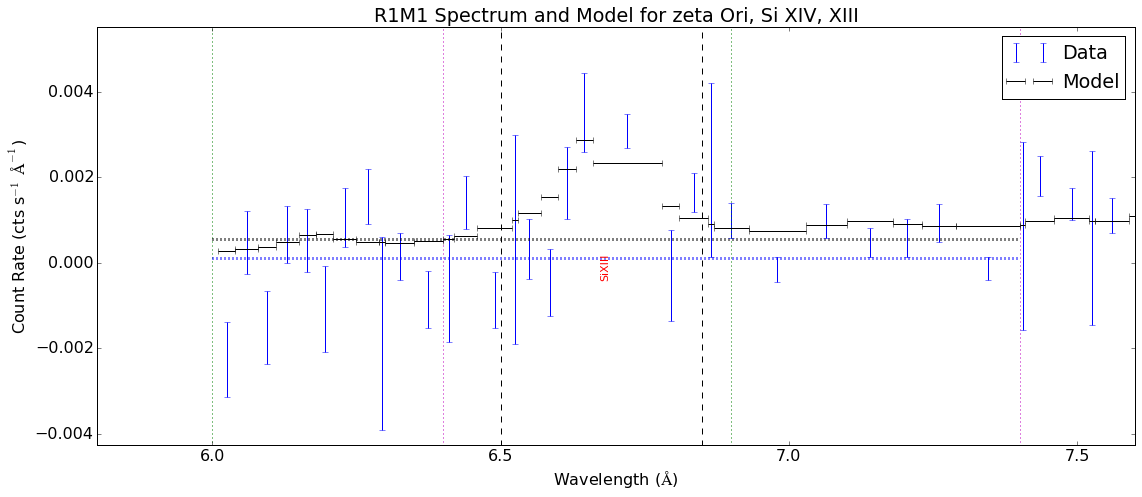

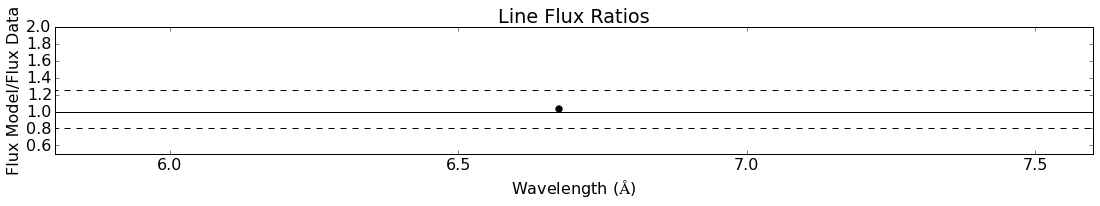

In [613]:
plotspecrange(6.0,7.4,L1, data1, model1, err1, binw1,ratio1,loc,name,avecont_data1,avecont_model1,llbound,ulbound,lbound,rbound,lrbound,urbound,'R1M1 Spectrum and Model for zeta Ori, Si XIV, XIII')


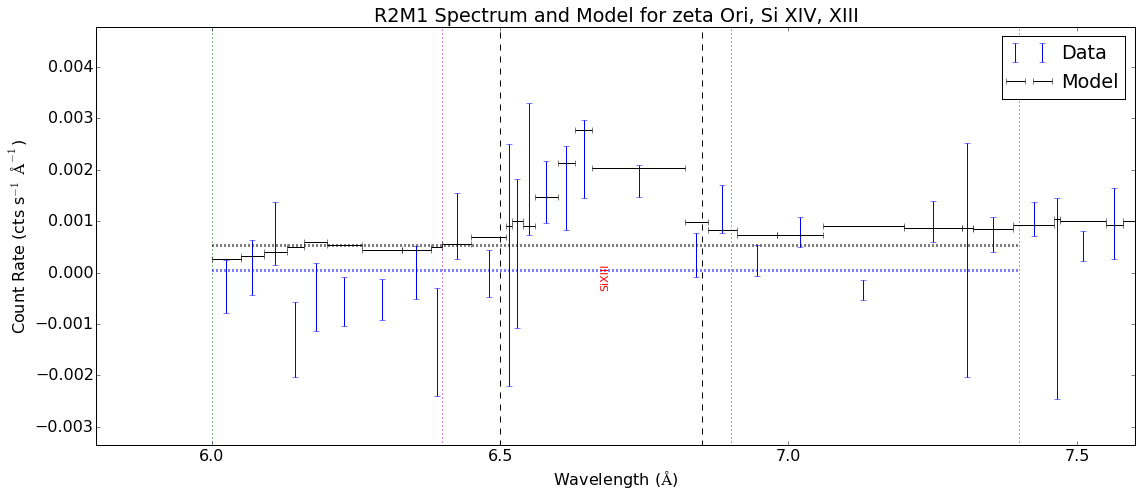

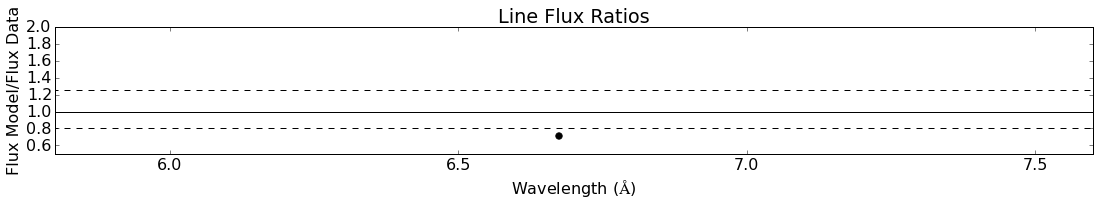

In [614]:
plotspecrange(6.0,7.4,L2, data2, model2, err2, binw2,ratio2,loc,name,avecont_data2,avecont_model2,llbound,ulbound,lbound,rbound,lrbound,urbound,'R2M1 Spectrum and Model for zeta Ori, Si XIV, XIII')


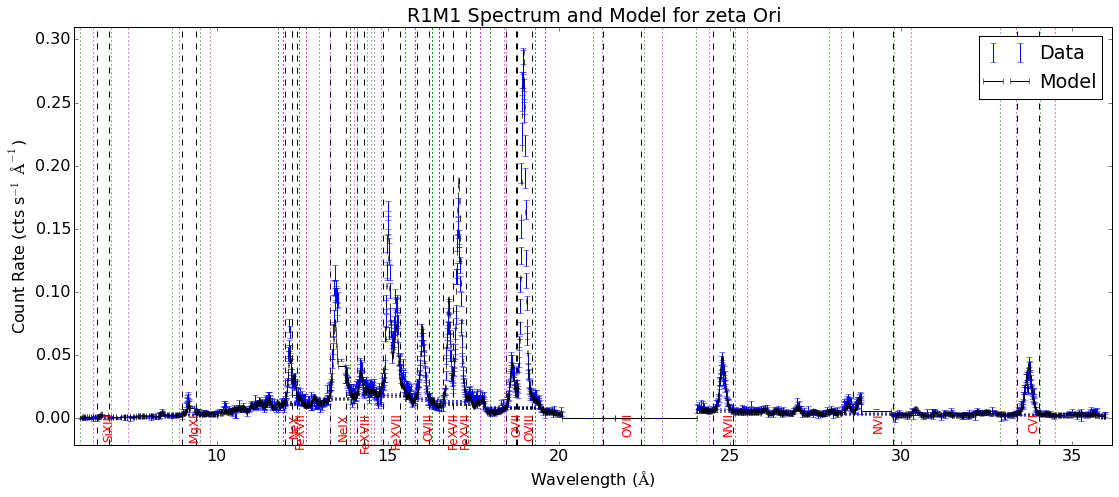

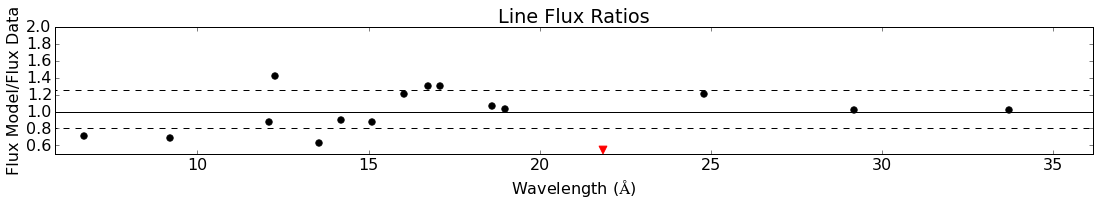

([33.710000000000001,
  29.175000000000001,
  24.800000000000001,
  21.850000000000001,
  18.984999999999999,
  18.600000000000001,
  17.100000000000001,
  16.75,
  16.024999999999999,
  15.1,
  14.199999999999999,
  13.539999999999999,
  12.274999999999999,
  12.1,
  9.1999999999999993,
  6.6749999999999998],
 [1.0221395085730758,
  1.0144724251069801,
  1.2110240604851217,
  0,
  1.0255269389110604,
  1.0631145630066263,
  1.3045802333797951,
  1.3017220423075155,
  1.2048620297179664,
  0.87947774402356105,
  0.89807392160183364,
  0.63202951397056384,
  1.4164241326544957,
  0.87762040964659527,
  0.68285944429926859,
  0.71558002114203345])

In [602]:
plotspecfull(L2, data2, model2, err2, binw2,ratio2,loc,name,avecont_data2,avecont_model2,llbound,ulbound,lbound,rbound,lrbound,urbound,"R1M1 Spectrum and Model for zeta Ori")
loc, ratio2

##Section 3: Focusing in on the line ratios

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


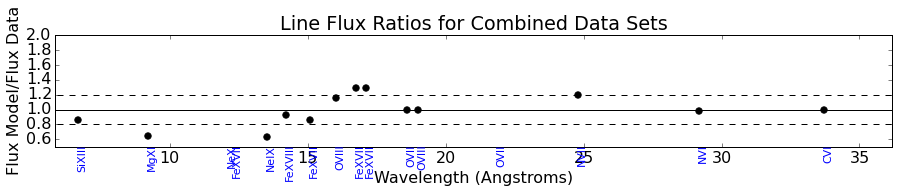

In [534]:
# First (for XMM spectra), create a let's also create and plot a summed ratio vector ((model1+model2)/(data1+data2))

sratio = [] # summed ratio for two spectra
for i in range(len(name)):
    [f_data1, ndata1] = flux(lbound[i], rbound[i], L1, data1)
    [f_model1, nmodel1] = flux(lbound[i], rbound[i], L1, model1)
    fcont_data1 = ndata1*contflux(llbound[i], ulbound[i], lrbound[i], urbound[i], L1, data1)
    fcont_model1 = nmodel1*contflux(llbound[i], ulbound[i], lrbound[i], urbound[i], L1, model1)
    
    [f_data2, ndata2] = flux(lbound[i], rbound[i], L2, data2)
    [f_model2, nmodel2] = flux(lbound[i], rbound[i], L2, model2)
    fcont_data2 = ndata2*contflux(llbound[i], ulbound[i], lrbound[i], urbound[i], L2, data2)
    fcont_model2 = nmodel2*contflux(llbound[i], ulbound[i], lrbound[i], urbound[i], L2, model2)
    
    sratio.append(((f_model1-fcont_model1) + (f_model2-fcont_model2))/((f_data1-fcont_data1) + (f_data2-fcont_data2)))

#plotting
plt.rcParams['figure.figsize'] = (15.0, 2.0)  #make size comparable to other ratio plots
plt.scatter(loc,sratio, color='k', s=40)
#label the lines
outlier_high = []
high_x = []
outlier_low = []
low_x = []
for i in range(len(name)):
    plt.text(loc[i], .4, name[i], fontsize='11', rotation='vertical', color='blue')
    if (sratio[i]>2):
        outlier_high.append(loc[i])
        high_x.append(1.95)
    if (sratio[i]<.5):
        outlier_low.append(loc[i])
        low_x.append(.55)
plt.scatter(outlier_high, high_x, color='r', marker='^', s=60)
plt.scatter(outlier_low, low_x, color='r', marker='v', s=60)
plt.hlines(1,np.min(L1)-1, np.max(L1)+1) # horizontal line at 1 for entire xrange (1 is agreement)
plt.hlines(.8,np.min(L1)-1, np.max(L1)+1, color = 'k', linestyles='dashed') # horizontal line for 20% below
plt.hlines(1.2,np.min(L1)-1, np.max(L1)+1, color = 'k', linestyles='dashed') # horizontal line for 20% above
plt.xlim([np.min(L1)-.2,np.max(L1)+.2])
plt.ylim([.5,2])
plt.title('Line Flux Ratios for Combined Data Sets')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Flux Model/Flux Data')
plt.show()

#loc, sratio

In [535]:
# Look at mean and standard deviation of each group of ratios

mean1 = np.mean(ratio1)
std1 = np.std(ratio1)
mean2 = np.mean(ratio2)
std2 = np.std(ratio2)
means = np.mean(sratio)
stds = np.std(sratio)

print("First data set line flux ratios:")
print("    Mean = " + str(mean1))
print("    Std  = " + str(std1))

print("Second data set line flux ratios:")
print("    Mean = " + str(mean2))
print("    Std  = " + str(std2))

print("Summed line flux ratios:")
print("    Mean = " + str(means))
print("    Std  = " + str(stds))

First data set line flux ratios:
    Mean = 0.756727041566
    Std  = 0.607650606081
Second data set line flux ratios:
    Mean = 0.953094186802
    Std  = 0.332660920494
Summed line flux ratios:
    Mean = nan
    Std  = nan


In [536]:
# get percentage of lines within a user specified uncertainty bound (here I choose 20%, since that is what I show in figs)

def percent_inside(tolerate,ratio):
    n = 0
    for i in range(len(ratio)):
        if ((ratio[i]<(1+tolerate)) & (ratio[i]>(1-tolerate))):
            n = n+1
    return n/float(len(ratio))

print('Percentage of lines in 1st data set within 50% of unity: ' + str(percent_inside(.5,ratio1)))
print('Percentage of lines in 2nd data set within 50% of unity: ' + str(percent_inside(.5,ratio2)))

Percentage of lines in 1st data set within 50% of unity: 0.8125
Percentage of lines in 2nd data set within 50% of unity: 0.9375


In [537]:
# Explicitly find and list lines where .5>R and 2<R and display them as poorly fit for the pure ratios

over = 2 # set upper tolerable limit
under = .5 # set lower tolerable limit

for i in range(len(name)):
    if (ratio1[i] >= over):
        print("Data 1 model overestimates " + name[i] + " with ratio of " + str(ratio1[i]) + ".      data 2 model is " +str(ratio2[i]))
    if (ratio1[i] <= under):
        print("Data 1 model underestimates " + name[i] + " with ratio of " + str(ratio1[i]) + ".      data 2 model is " +str(ratio2[i]))
    if (ratio2[i] >= over):
        print("Data 2 model overestimates " + name[i] + " with ratio of " + str(ratio2[i]) + ".      data 1 model is " +str(ratio1[i]))
    if (ratio2[i] <= under):
        print("Data 2 model underestimates " + name[i] + " with ratio of " + str(ratio2[i]) + ".      data 1 model is " +str(ratio1[i]))
    

    
# uncomment the following code to organize this list by overestimated elements and underestimated elements:

#print("Overestimated lines:")
#for i in range(len(name)):
#    if (ratio1[i] >= over):
#        print("Data 1 model: " + name[i] + " with ratio " + str(ratio1[i]))
#    if (ratio2[i] >= over):
#        print("Data 2 model: " + name[i] + " with ratio " + str(ratio2[i]))

#print("Underestimated lines:")
#for i in range(len(name)):
#    if (ratio1[i] <= under):
#        print("Data 1 model: " + name[i] + " with ratio " + str(ratio1[i]))
#    if (ratio2[i] <= under):
#        print("Data 2 model: " + name[i] + " with ratio " + str(ratio2[i]))

Data 2 model underestimates OVII with ratio of 0.      data 1 model is 1.12806195328
Data 1 model underestimates NeIX with ratio of -1.11163036016.      data 2 model is 0.632029513971
Data 1 model underestimates FeXVII with ratio of 0.      data 2 model is 1.41642413265
Data 1 model underestimates NeX with ratio of 0.      data 2 model is 0.877620409647
